In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import subprocess

In [2]:
#constants
mue0= 4*cmath.pi* 1e-7
epsilon0 = 8.854187817e-12
c0 = 299792458

In [3]:
# program flow parameters 
unv_scaling = False # if true, the given .unv-file will be scaled

In [4]:
# just functions needed in the following cell(s)

# function for reading a structured ASCII-File line by line
def read_ascii_table(filename):
    with open(filename, 'r') as file:
        table = [line.strip().split() for line in file]
    return table

def rw_scattering_parameter(file_path, e_direction, refl_trans, a, frequencies):
    """
    Calculates the scattering parameters for each port at multiple frequencies based on the input data.

    Parameters:
    - file_path (str): The file path to the ASCII table containing the input data (obtained by SaveScalar).
    - e_direction (list): A list of directions for the electric fields of each port (1: x, 2: y, 3: z)
    - refl_trans (list): A list indicating wether it is an input (reflection) or output (transmission) port (1: input).
    - a (float): The width of the waveguide in m
    - frequencies (list): A list of frequencies at which the scattering parameters need to be calculated. 
    These need to coincide with the simulated frequencies. 
    Returns:
    - dict: A dictionary containing the scattering parameters for each port at each frequency.
            The keys are the consecuitve frequency index, and the values are dictionaries containing the scattering parameters for each port.
    """
    try:
        # file name of the ASCII table
        filename = file_path
        
        # read the ASCII table
        table_data = read_ascii_table(filename)
        
        # calculate the number of ports
        number_of_ports = len(e_direction)

        # check for consistency with respect to number of ports
        number_of_ports = len(e_direction)
        if len(refl_trans) != number_of_ports:
            raise ValueError("Number of ports in e_direction and refl_trans is not consistent.")
        
        # check if enough columns are available
        expected_columns = number_of_ports * 6
        if len(table_data[0]) < expected_columns:
            raise ValueError(f"Expecting at least {expected_columns} columns in the table, but found: {len(table_data[0])}.")
                
        # check if the number of rows in the table is sufficient for the given frequencies
        if len(table_data) < len(frequencies):
            raise ValueError("Not enough data rows in the table for the given frequencies.")

        # initialize dictionary to store scattering parameters for each port at the current frequency
        frequency_parameters = {}
        
        # iterate over each frequency
        for f_index, frequency in enumerate(frequencies):
                       
            # calculate reference field value for the current frequency
            k0 = cmath.pi * 2 * frequency / c0
            kc = cmath.pi / a
            reference_value = complex(0, 1) * k0 / kc
            
            # calculate and store the scattering parameters for each port at the current frequency
            row = table_data[f_index]
            # initialize port parameters for the current row
            port_parameters = {}
            for port in range(number_of_ports):
                E_re_index = (e_direction[port]) - 1 + port * 6
                E_im_index = (e_direction[port]) - 1 + 3 + port * 6
                E_re = float(row[E_re_index])
                E_im = float(row[E_im_index])
                E = (E_re + complex(0, 1) * E_im)
                E = (E_re + complex(0, 1) * E_im) * cmath.pi / 2 * 1 / reference_value
                if refl_trans[port] == 1:
                    E = E - 1
                port_parameters[port + 1] = E

            frequency_parameters[f_index] = port_parameters
            
        return frequency_parameters
            
    except FileNotFoundError:
        print(f"Error: The file '{filename}' could not be found.")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None



def rw_scattering_parameter_ef(file_path, e_direction, refl_trans, a, b, frequencies):
    """
    Calculates the scattering parameters for each port at multiple frequencies based on the input data.

    Parameters:
    - file_path (str): The file path to the ASCII table containing the input data (obtained by SaveScalar).
    - e_direction (list): A list of directions for the electric fields of each port (1: x, 2: y, 3: z)
    - refl_trans (list): A list indicating wether it is an input (reflection) or output (transmission) port (1: input).
    - a (float): The width of the waveguide in m
    - b (float): The height of the wqaveguid in m
    - frequencies (list): A list of frequencies at which the scattering parameters need to be calculated. 
    These need to coincide with the simulated frequencies. 
    Returns:
    - dict: A dictionary containing the scattering parameters for each port at each frequency.
            The keys are the consecuitve frequency index, and the values are dictionaries containing the scattering parameters for each port.
    """
    try:
        # File name of the ASCII table
        filename = file_path
        
        # Read the ASCII table
        table_data = read_ascii_table(filename)
        
        # Calculate the number of ports
        number_of_ports = len(e_direction)

        # Überprüfen, ob die Anzahl der Ports konsistent ist
        number_of_ports = len(e_direction)
        if len(refl_trans) != number_of_ports:
            raise ValueError("Number of ports in e_direction and refl_trans is not consistent.")
        
        # Überprüfen, ob genügend Spalten in der Tabelle vorhanden sind
        expected_columns = number_of_ports * 6
        if len(table_data[0]) < expected_columns:
            raise ValueError(f"Expecting at least {expected_columns} columns in the table, but found: {len(table_data[0])}.")
                
        # Check if the number of rows in the table is sufficient for the given frequencies
        if len(table_data) < len(frequencies):
            raise ValueError("Not enough data rows in the table for the given frequencies.")

        # Initialize dictionary to store scattering parameters for each port at the current frequency
        frequency_parameters = {}
        
        # Iterate over each frequency
        for f_index, frequency in enumerate(frequencies):
                       
            # Calculate reference field value for the current frequency
            k0 = cmath.pi * 2 * frequency / c0
            kc = cmath.pi / a
            reference_value = complex(0, 1) * k0 / kc
            
            # Calculate and store the scattering parameters for each port at the current frequency
            row = table_data[f_index]
            # Initialize port parameters for the current row
            port_parameters = {}
            for port in range(number_of_ports):
                E_re_index = (e_direction[port]) - 1 + port * 6
                E_im_index = (e_direction[port]) - 1 + 3 + port * 6
                E_re = float(row[E_re_index])
                E_im = float(row[E_im_index])
                E = (E_re + complex(0, 1) * E_im)
                E = (E_re + complex(0, 1) * E_im) * cmath.pi / 2 * 1 / reference_value
                if refl_trans[port] == 1:
                    #using the energy functional to calculate S11:
                    E_re_index = number_of_ports * 6
                    E_im_index = number_of_ports * 6 + 1
                    E_re = float(row[E_re_index])
                    E_im = float(row[E_im_index])
                    E=-complex(0,1)*mue0*kc**2/(cmath.sqrt(k0**2-kc**2)*k0**2*a*b)*(E_re+complex(0,1)*E_im)-1
                
                port_parameters[port + 1] = E

            frequency_parameters[f_index] = port_parameters
            
        return frequency_parameters
            
    except FileNotFoundError:
        print(f"Error: The file '{filename}' could not be found.")
        return None
    except ValueError as e:
        print(f"Error: {e}")
        return None


# function for calculating the Hm0 mode cut-off frequency of a rectangular waveguide
def rw_cut_off_frequency(a, epsilon_r, m):
    fc=m*c0/(2*a*cmath.sqrt(epsilon_r)) 
    return fc

# function for calculating the H10 mode wave impedance of a rectangular waveguide
def rw_impedance(a, b, epsilon_r, f):
    Z=cmath.sqrt(mue0/(epsilon0*epsilon_r))*1/cmath.sqrt(1-(rw_cut_off_frequency(a,epsilon_r,1)/f)**2)
    return Z

# function for calculating the H10 mode propagation constant of a rectangular waveguide
def rw_propagation_constant(a, b, epsilon_r, f):
    gamma=2*cmath.pi*rw_cut_off_frequency(a,epsilon_r,1)/c0*cmath.sqrt(epsilon_r)*cmath.sqrt(1-(f/rw_cut_off_frequency(a,epsilon_r,1))**2)
    return gamma
      
# function for calculating the reflection parameter r when terminating impedance and wave impedance is given
def r_from_Z(Z0,Z):
    r = (Z-Z0) / (Z+Z0)
    return r

In [5]:
# scaling the mesh, given in freecad_mesh_gmsh.unv. Output is written to mesh.unv
if unv_scaling:      
    # open and read .unv-file
    with open('freecad_mesh_gmsh.unv', 'r') as file:
        lines = file.readlines()

    # scaling the mesh
    scaling_factor = 1/1000  # millimeter to meter

    # flag which is used to skip the first rows
    start_processing = False

    # checking all lines and scaling of the coordinates
    for i, line in enumerate(lines):
        
        if not start_processing and i >= 17:
            start_processing = True

        if start_processing:
            # check if row contains the coordinate format
            if any(char.isdigit() for char in line) and 'E' in line and line.count('.') == 3:
                # divide line in order to get separate x, y,z coordinates
                coordinates = line.strip().split()
                # scale coordinates and perserve format
                scaled_coordinates = ' '.join([f'{float(coord) * scaling_factor:.16E}' for coord in coordinates])
                # replace line with scaled coordinates
                lines[i] = scaled_coordinates + '\n'

    # saving the scales mesh as .unv-file
    with open('mesh.unv', 'w') as file:
        file.writelines(lines)

    print("Scaling done")

In [6]:
# calculation of the scattering parameters, analytic solution.

# calculate the analytical solution of R (S11) and T (S21) using the transfer matrix approach.
# Attention: This solution is based on the harmonic time dependency of kind Re{e^(j*om,ega*t)} whereas
# VectorHelmholtz solver assumes Re{e^(-j*om,ega*t)}. This has to be taken into account when considering
# the phases.
r=[]
t=[]
epsilon_r=1.5
a=10e-2
b=5e-2
f1=1.6e9
f2=2.3e9

freq_values = np.linspace(f1, f2, 141)
l1=2.5e-1
l2=2e-1
l3=1.5e-1

for f in freq_values:
   # wave impedances
   Z1=rw_impedance(a, b, 1.0, f)
   Z3=Z1
   Z2=rw_impedance(a, b, epsilon_r, f)
   
   #transition matrices
   D32 = 1/(1+r_from_Z(Z3,Z2)) * np.array([[1, r_from_Z(Z3,Z2)],
                                           [r_from_Z(Z3,Z2), 1]])
   D21 = 1/(1+r_from_Z(Z2,Z1)) * np.array([[1, r_from_Z(Z2,Z1)],
                                           [r_from_Z(Z2,Z1), 1]])

   #propagation matrices
   gamma3=rw_propagation_constant(a, b, 1, f)
   P3 = np.array([[cmath.exp(gamma3*l3), 0],
                    [0, cmath.exp(-gamma3*l3)]])
   gamma2=rw_propagation_constant(a, b, epsilon_r, f)
   P2 = np.array([[cmath.exp(gamma2*l2), 0],
                    [0, cmath.exp(-gamma2*l2)]])
   gamma1=rw_propagation_constant(a, b, 1, f)
   P1 = np.array([[cmath.exp(gamma1*l1), 0],
                    [0, cmath.exp(-gamma1*l1)]])
   #transfer matrix
   transfer_matrix=np.matmul(P3,np.matmul(D32,np.matmul(P2,np.matmul(D21,P1))))
   r.append(transfer_matrix[2-1, 1-1]/transfer_matrix[1-1, 1-1])
   t.append(1/transfer_matrix[1-1, 1-1])


In [7]:
#importing the results of the FEM-simulation
result=rw_scattering_parameter("./results/port_data.dat", [2, 2], [1, 0], 0.1, freq_values)
result2=rw_scattering_parameter_ef("./results/port_data.dat", [2, 2], [1, 0], 0.1, 0.05, freq_values)
port_1_values = [params[1] for params in result.values()]
port_2_values = [params[2] for params in result.values()]
port_1_values_ef = [params[1] for params in result2.values()]

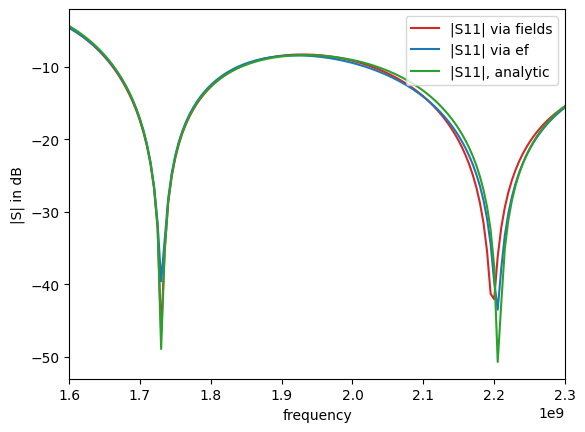

In [8]:
# create plot S11
fig, ax1 = plt.subplots()

# y-axis
ax1.set_xlabel('frequency')
ax1.set_ylabel('|S| in dB')
ax1.plot(freq_values, 20*np.log10((np.abs(port_1_values))), color='tab:red', label='|S11| via fields')
ax1.plot(freq_values, 20*np.log10((np.abs(port_1_values_ef))), color='tab:blue', label='|S11| via ef')
ax1.plot(freq_values, 20*np.log10((np.abs(r))), color='tab:green', label='|S11|, analytic')
ax1.tick_params(axis='y')

# add legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')
ax1.set_xlim(min(freq_values), max(freq_values))
plt.savefig('./images/S11.png')
plt.show()


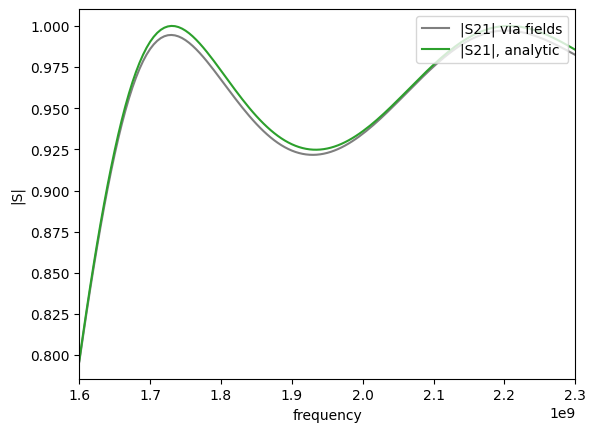

In [9]:
# create plot S21
fig, ax1 = plt.subplots()

# y-axis
ax1.set_xlabel('frequency')
ax1.set_ylabel('|S|')
ax1.plot(freq_values, np.abs(port_2_values), color='tab:grey', label='|S21| via fields')
ax1.plot(freq_values, np.abs(t), color='tab:green', label='|S21|, analytic')
ax1.tick_params(axis='y')

# add legend
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper right')
ax1.set_xlim(min(freq_values), max(freq_values))
plt.savefig('./images/S21.png')
plt.show()